# Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import pandas as pd
import joblib
import keras
import tensorflow as tf
import os
import time
import math
import keras
from keras.models import Input, Model
from keras.layers import Dense, LSTM, Embedding
from keras.layers import Layer
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras import layers
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.constraints import max_norm
from sklearn import metrics
from scipy import interp
from keras.models import Model

In [3]:
import numpy as np
import gensim
from gensim.corpora import WikiCorpus
from gensim.models import KeyedVectors
list_emotions = ['negative', 'neutral', 'positive']

In [4]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install contractions
import contractions
nltk.download('universal_tagset')
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 327kB 20.1MB/s 
     |████████████████████████████████| 266kB 46.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85390 sha256=2e506f3c21c7e359ea68937e700d81f44069611649431ec2c7e67446bd55d754
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unz

# Make data

In [ ]:
def makeDF(path):
  tree = ET.parse(path)
  root = tree.getroot()
  df=pd.DataFrame(columns=['context','target','output'])
  for sentence in root:
    for subelem in sentence:  
        if len(subelem.text) >13 :
          tt= subelem.text
        for subsub in subelem:
          for i in subsub.attrib :
            if i == 'term':
              newrow={'context' : tt,'target' : subsub.attrib['term'] , 'output' :  subsub.attrib['polarity']}
              df = df.append(newrow, ignore_index=True)
  return df

In [ ]:
train_laptop = makeDF('/content/drive/MyDrive/DL/Assignment4/ABSA complete Dataset/ABSA Train/Laptops_Train.xml')
test_laptop = makeDF('/content/drive/MyDrive/DL/Assignment4/ABSA complete Dataset/ABSA Test/Laptops_Test_Gold.xml')
train_rest = makeDF('/content/drive/MyDrive/DL/Assignment4/ABSA complete Dataset/ABSA Train/Restaurants_Train.xml')
test_rest = makeDF('/content/drive/MyDrive/DL/Assignment4/ABSA complete Dataset/ABSA Test/Restaurants_Test_Gold.xml')
train_laptop.to_csv('/content/drive/MyDrive/DL/Assignment4/train_laptop.csv')
test_laptop.to_csv('/content/drive/MyDrive/DL/Assignment4/test_laptop.csv')
train_rest.to_csv('/content/drive/MyDrive/DL/Assignment4/train_rest.csv')
test_rest.to_csv('/content/drive/MyDrive/DL/Assignment4/test_rest.csv')

In [ ]:
embeddings_dict = joblib.load('/content/drive/MyDrive/DL/Glove_Embedding')

In [ ]:
embeddings_dict = joblib.load('/content/drive/MyDrive/ML/Group5_MLProject_EndSem/Glove_Embedding')

In [ ]:
def max_length_sentence(data):
  # dictionary_final = []
  max = 0
  for s in data:
    words = preprocessing(s)
    if max < len(words):
      max = len(words)
    # for word in words:
    #   if word not in dictionary_final:
    #     dictionary_final.append(word)
  return max

In [ ]:
max_sentence = max_length_sentence(train_rest['target'])
print(max_sentence)

14


In [ ]:
max_sentence = max_length_sentence(train_rest['context'])
print(max_sentence)

33


In [ ]:
max_sentence = max_length_sentence(test_rest['context'])
print(max_sentence)

31


In [ ]:
max_sentence = max_length_sentence(train_laptop['target'])
print(max_sentence)

6


In [ ]:
max_sentence = max_length_sentence(test_laptop['target'])
print(max_sentence)

9


In [ ]:
max_sentence = max_length_sentence(train_laptop['context'])
print(max_sentence)

37


In [ ]:
max_sentence = max_length_sentence(test_laptop['context'])
print(max_sentence)

39


# Data Loading and Other functions

In [5]:
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# def equilising(data, data_target, y_t):
#   ros = RandomOverSampler(random_state = 42) 
#   X_res, y_res = ros.fit_resample(data, y_t)
#   X_res_target, _ = ros.fit_resample(data_target, y_t)
#   return X_res, X_res_target, y_res

In [6]:
# X_train_padded1, X_train_padded_target1, y_train_rest1 = equilising(X_train_padded, X_train_padded_target, y_train_rest)

In [7]:
rest_glove = joblib.load('/content/drive/MyDrive/DL/Assignment_4/restaurant_GloVe')
laptop_glove = joblib.load('/content/drive/MyDrive/DL/Assignment_4/laptop_GloVe')

In [8]:
laptop_glove_target = joblib.load('/content/drive/MyDrive/DL/Assignment_4/laptop_GloVe_target')
rest_glove_target = joblib.load('/content/drive/MyDrive/DL/Assignment_4/restaurant_GloVe_target')

In [9]:
train_laptop = pd.read_csv('/content/drive/MyDrive/DL/Assignment_4/train_laptop.csv')
test_laptop = pd.read_csv('/content/drive/MyDrive/DL/Assignment_4/test_laptop.csv')
train_rest = pd.read_csv('/content/drive/MyDrive/DL/Assignment_4/train_rest.csv')
test_rest = pd.read_csv('/content/drive/MyDrive/DL/Assignment_4/test_rest.csv')

In [10]:
def simplify(df,y):
  corpus = []
  for i in range(0, y.size):
    review = re.sub('[^a-zA-Z0-9]', ' ', str(df[i]))
    review = review.lower()
    review = review.split(' ')
    review = ' '.join(review)
    corpus.append(review)
  return corpus

In [11]:
def preprocessing(corpus_train, corpus_test, embeddings_dict, max_sentence_length=40):

  t = Tokenizer()
  t.fit_on_texts(corpus_train)
  vocab_size = len(t.word_index)+1
  X_train_encoded = t.texts_to_sequences(corpus_train)
  X_test_encoded = t.texts_to_sequences(corpus_test)
  X_train_padded = pad_sequences(X_train_encoded,maxlen=max_sentence_length,padding='post')
  X_test_padded = pad_sequences(X_test_encoded,maxlen=max_sentence_length,padding='post')
  embeddings_matrix = np.zeros((vocab_size,300))
  for word,i in t.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
      embeddings_matrix[i] = embedding_vector
      
  return embeddings_matrix, X_train_padded, X_test_padded, vocab_size

# IAN, WithoutAttention and other helper functions  

In [13]:
def plotting_epochs(training_, validation_, lossOrAccu, size=(6, 4)):
  plt.figure(figsize=size)
  plt.plot(training_, 'black', linewidth=2.0)
  plt.plot(validation_, 'blue', linewidth=2.0)
  plt.legend(['Training '+lossOrAccu, 'Validation '+lossOrAccu], fontsize=14)
  plt.xlabel('Epochs', fontsize=10)
  plt.ylabel(lossOrAccu, fontsize=10)
  plt.title(lossOrAccu+' Curves', fontsize=12)

In [14]:
class WithoutAttention(tf.keras.Model):

    def __init__(self, embeddings_matrix=None, embeddings_matrix_target=None, max_aspect_len=10):
        super(WithoutAttention, self).__init__()

        self.embedding_dim = 300
        self.n_hidden = 300
        self.n_class = 3
        self.l2_reg = 1e-5

        self.max_aspect_len = max_aspect_len
        self.max_context_len = 40
        self.embedding_matrix = embeddings_matrix
        self.embedding_matrix_target = embeddings_matrix_target

        self.aspect_lstm = tf.keras.layers.LSTM(self.n_hidden,
                                                return_sequences=True,
                                                recurrent_initializer='glorot_uniform',
                                                stateful=True)
        self.context_lstm = tf.keras.layers.LSTM(self.n_hidden,
                                                 return_sequences=True,
                                                 recurrent_initializer='glorot_uniform',
                                                 stateful=True)
        
        self.output_fc = tf.keras.layers.Dense(self.n_class, kernel_regularizer=tf.keras.regularizers.l2(l=self.l2_reg))

    
    def call(self, data, dropout=0.5):
        # print(1)
        aspects, contexts, labels, aspect_lens, context_lens = data

        aspect_inputs = tf.nn.embedding_lookup(self.embedding_matrix_target, aspects)
        aspect_inputs = tf.cast(aspect_inputs, tf.float32)
        # aspect_inputs = self.transpose(aspect_inputs)
        # print(1)
        context_inputs = tf.nn.embedding_lookup(self.embedding_matrix, contexts)
        context_inputs = tf.cast(context_inputs, tf.float32)
        # context_inputs = self.transpose(context_inputs)
        # print(context_inputs.shape, aspect_inputs.shape)
        aspect_outputs = self.aspect_lstm(aspect_inputs)
        aspect_outputs = tf.nn.max_pool1d(aspect_outputs, 3, 1, "SAME")
        aspect_outputs = tf.reduce_sum(aspect_outputs, 1)
        # print(aspect_avg.shape, aspect_outputs.shape)
        context_outputs = self.context_lstm(context_inputs)
        context_outputs = tf.nn.max_pool1d(context_outputs, 3, 1, "SAME")
        
        context_outputs = tf.reduce_sum(context_outputs, 1)
        # print(context_outputs1.shape)
        
        rep = tf.concat([aspect_outputs, context_outputs], 1)
        predict = self.output_fc(rep)
        
        return predict, labels, aspect_outputs, context_outputs

In [15]:
class IAN(tf.keras.Model):

    def __init__(self, embeddings_matrix=None, embeddings_matrix_target=None, max_aspect_len=10):
        super(IAN, self).__init__()

        self.embedding_dim = 300
        self.n_hidden = 300
        self.n_class = 3
        self.l2_reg = 1e-5

        self.max_aspect_len = max_aspect_len
        self.max_context_len = 40
        self.embedding_matrix = embeddings_matrix
        self.embedding_matrix_target = embeddings_matrix_target

        self.aspect_lstm = tf.keras.layers.LSTM(self.n_hidden,
                                                return_sequences=True,
                                                recurrent_initializer='glorot_uniform',
                                                stateful=True)
        self.context_lstm = tf.keras.layers.LSTM(self.n_hidden,
                                                 return_sequences=True,
                                                 recurrent_initializer='glorot_uniform',
                                                 stateful=True)
        rand_state = np.random.RandomState(42)
        self.aspect_w = rand_state.uniform(-.1, .1, [self.n_hidden, self.n_hidden])
        self.aspect_b = np.zeros([self.n_hidden]) 
        self.context_w = rand_state.uniform(-.1, .1, [self.n_hidden, self.n_hidden])
        self.context_b = np.zeros([self.n_hidden])
        
        self.output_fc = tf.keras.layers.Dense(self.n_class, kernel_regularizer=tf.keras.regularizers.l2(l=self.l2_reg))

    # def transpose(self, X):
    #   new_X = np.full((X.shape[0], X.shape[2], X.shape[1]), 0, dtype=float)
    #   for i in range(X.shape[0]):
    #     new_X[i] = tf.transpose(X[i])
    #   return new_X

    # def build(self, input_shape):
    #     self.aspect_w = self.add_weight(shape=(self.n_hidden, self.n_hidden),initializer="normal")
    #     self.aspect_b = self.add_weight(shape=(self.n_hidden,),initializer="zeros")
    #     self.context_w = self.add_weight(shape=(self.n_hidden, self.n_hidden),initializer="normal")
    #     self.context_b = self.add_weight(shape=(self.n_hidden,),initializer="zeros")        
    #     super(IAN, self).build(input_shape)

    def call(self, data, dropout=0.5):
        # print(1)
        aspects, contexts, labels, aspect_lens, context_lens = data

        aspect_inputs = tf.nn.embedding_lookup(self.embedding_matrix_target, aspects)
        aspect_inputs = tf.cast(aspect_inputs, tf.float32)
        # aspect_inputs = self.transpose(aspect_inputs)
        # print(1)
        context_inputs = tf.nn.embedding_lookup(self.embedding_matrix, contexts)
        context_inputs = tf.cast(context_inputs, tf.float32)
        # context_inputs = self.transpose(context_inputs)
        # print(context_inputs.shape, aspect_inputs.shape)
        aspect_outputs = self.aspect_lstm(aspect_inputs)
        aspect_outputs = tf.nn.max_pool1d(aspect_outputs, 3, 1, "SAME")
        aspect_avg = tf.reduce_mean(aspect_outputs, 1)
        # print(aspect_avg.shape, aspect_outputs.shape)
        context_outputs = self.context_lstm(context_inputs)
        context_outputs = tf.nn.max_pool1d(context_outputs, 3, 1, "SAME")
        context_avg = tf.reduce_mean(context_outputs, 1)
        # context_outputs1 = tf.reduce_sum(context_outputs, 1)
        # print(context_outputs1.shape)
        aspect_att = tf.nn.softmax(tf.nn.tanh(tf.einsum('ijk,kl,ilm->ijm', aspect_outputs, self.aspect_w,
                                                        tf.expand_dims(context_avg, -1)) + self.aspect_b), axis=1)
        
        aspect_rep = tf.reduce_sum(aspect_att * aspect_outputs, 1)
        
        context_att = tf.nn.softmax(tf.nn.tanh(tf.einsum('ijk,kl,ilm->ijm', context_outputs, self.context_w,
                                                         tf.expand_dims(aspect_avg, -1)) + self.context_b), axis=1)
        context_rep = tf.reduce_sum(context_att * context_outputs, 1)
        # print(context_rep.shape)
        rep = tf.concat([aspect_rep, context_rep], 1)
        predict = self.output_fc(rep)
        
        return predict, labels, aspect_att, context_att

In [16]:
def run(model, train_data, test_data, stopping_accuracy=0.70, run_only='both'):
    
    max_acc, step = 0., -1
    train_accuracy, test_accuracy, train_loss_list, test_loss_list = [], [], [], [] 
    train_data_size = len(train_data[0])
    train_data = tf.data.Dataset.from_tensor_slices(train_data)
    train_data = train_data.shuffle(buffer_size=train_data_size).batch(batch_size, drop_remainder=True)
    # print(1)
    test_data_size = len(test_data[0])
    test_data = tf.data.Dataset.from_tensor_slices(test_data)
    test_data = test_data.batch(batch_size, drop_remainder=True)
    # print(1)
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate) 
    
    # print(1)
    for i in range(n_epoch):
        start_time = time.time()
        cost, predict_list, labels_list = 0., [], []
        if run_only == 'both':
          for (iterator, data) in enumerate(train_data):
              
              # print(type(data))
              with tf.GradientTape() as tape:
                  predict, labels, aspect_att, context_att = model(data, dropout=0.5)
                  
                  loss_t = tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=labels)
                  loss = tf.reduce_mean(loss_t)
                  cost += tf.reduce_sum(loss_t)
                  # print(1)
              grads = tape.gradient(loss, model.variables)
              optimizer.apply_gradients(zip(grads, model.variables))
              predict_list.extend(tf.argmax(tf.nn.softmax(predict), 1).numpy())
              labels_list.extend(tf.argmax(labels, 1).numpy())
          train_acc, class_train_acc = evaluate(predict_list, labels_list)
          train_loss = cost / train_data_size
          train_accuracy.append(train_acc)
          train_loss_list.append(train_loss)

        cost, predict_list, labels_list = 0., [], []

        for (iterator, data) in enumerate(test_data):

            predict, labels, aspect_att1, context_att1 = model(data, dropout=0.5)
            # print(aspect_att1.shape)
            loss_t = tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=labels)
            cost += tf.reduce_sum(loss_t)
            predict_list.extend(tf.argmax(tf.nn.softmax(predict), 1).numpy())
            labels_list.extend(tf.argmax(labels, 1).numpy())
            # print(1)
        test_acc, class_test_acc = evaluate(predict_list, labels_list)
        test_loss = cost / test_data_size
        test_accuracy.append(test_acc)
        test_loss_list.append(test_loss)
        

        if test_acc  > max_acc :
            max_acc = test_acc
            step = i
            
        end_time = time.time()
        if run_only == 'both':
          print('Epoch {0:d}/{1:d}'.format(i+1,n_epoch), ": {0:.3f}sec".format((end_time - start_time)))
          print('===============>  train-loss=%.6f; train-acc=%.6f; validation-loss=%.6f; validation-acc=%.6f' % 
                (train_loss, train_acc, test_loss, test_acc))
          print('Classwise train accuracy:', class_train_acc) 
          print('Classwise test accuracy:', class_test_acc)
        
        else:
          print('Time: {0:.3f}sec'.format((end_time - start_time)))
          print('===============>  validation-loss=%.6f; validation-acc=%.6f' % 
                (test_loss, test_acc))
          print('Classwise test accuracy:', class_test_acc)
          break
        if test_acc > stopping_accuracy:
          break
    if run_only == 'both':
      print('\n\nThe max accuracy of testing results: acc %.3f of epoch %s' % (max_acc, step+1))
      return np.array(train_accuracy), np.array(test_accuracy), np.array(train_loss_list), np.array(test_loss_list)

Evaluate

In [17]:
def evaluate(y_pred, y_true):
    
    hit_count = np.zeros(3, dtype='int32')
    original_count = np.zeros(3, dtype='int32')
    n_test = len(y_true)

    for i in range(n_test):
        y_p = int(y_pred[i])
        y_g = y_true[i]
        original_count[y_g] += 1
        if y_p == y_g:
            hit_count[y_p] += 1

    total_hit = sum(hit_count)
    acc = float(total_hit) / n_test
    # print(hit_count[0])
    class_acc = []
    class_acc.append((hit_count[0] / original_count[0]))
    class_acc.append((hit_count[1] / original_count[1]))
    class_acc.append((hit_count[2] / original_count[2]))
    class_acc = np.round_(np.array(class_acc), decimals = 3)
    return acc, class_acc

In [18]:
def getting_attention_weights(X_test_padded, corpus_test, att_context, indx=0):
  tokenized_text = []
  attention_output = []
  for i in range(len(X_test_padded[indx])):
    try:
      if X_test_padded[indx][i] != 0:
        tokenized_text.append(corpus_test[indx].split()[i])
        attention_output.append(sum(att_context[indx][i]))
    except:
      pass
  attention_output = np.array(attention_output)
  attention_output1 = np.square(attention_output)
  sum_sqr = np.sqrt(np.sum(attention_output1))
  attention_output /= sum_sqr
  return tokenized_text, attention_output

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255, r, r))
    return 'background-color: %s' % color

# Laptop

In [12]:
corpus_train = simplify(train_laptop['context'], train_laptop['output'])
corpus_test = simplify(test_laptop['context'], test_laptop['output'])

In [19]:
embeddings_matrix, X_train_padded, X_test_padded, vocab_size = preprocessing(corpus_train, corpus_test, laptop_glove)

In [20]:
le = LabelEncoder()
y_train_laptop = le.fit_transform(train_laptop['output'])
y_test_laptop = le.transform(test_laptop['output'])
num_classes = np.unique(y_train_laptop).shape[0]
y_train_laptop1 = np_utils.to_categorical(y_train_laptop, num_classes)
y_test_laptop1 = np_utils.to_categorical(y_test_laptop, num_classes)

In [19]:
print(embeddings_matrix.shape, X_train_padded.shape, X_test_padded.shape, y_train_laptop1.shape)

(3091, 300) (2328, 40) (638, 40) (2328, 3)


In [21]:
corpus_train_target = simplify(train_laptop['target'], train_laptop['output'])
corpus_test_target = simplify(test_laptop['target'], test_laptop['output'])

In [22]:
embeddings_matrix_target, X_train_padded_target, X_test_padded_target, vocab_size_target = preprocessing(corpus_train_target, corpus_test_target, laptop_glove_target, max_sentence_length=10)

In [ ]:
print(embeddings_matrix_target.shape, X_train_padded_target.shape, X_test_padded_target.shape)

(813, 300) (2328, 10) (638, 10)


In [23]:
data = X_train_padded_target, X_train_padded, y_train_laptop1, np.full((X_train_padded.shape[0],), 10.), np.full((X_train_padded.shape[0],), 40.)
data_test = X_test_padded_target, X_test_padded, y_test_laptop1, np.full((X_test_padded.shape[0],), 10.), np.full((X_test_padded.shape[0],), 40.)

## WithoutAttention Model

In [28]:
batch_size = 64
learning_rate = 0.01
n_epoch = 10

In [31]:
model_1 = WithoutAttention(embeddings_matrix, embeddings_matrix_target)
train_accuracy, test_accuracy, train_loss, test_loss = run(model_1, data, data_test, stopping_accuracy=0.699)

Epoch 1/10 : 1.011sec
===============>  train-loss=6.495472; train-acc=0.516927; validation-loss=1.038161; validation-acc=0.515625
Classwise train accuracy: [0.502 0.308 0.628]
Classwise test accuracy: [0.948 0.039 0.591]
Epoch 2/10 : 0.949sec
===============>  train-loss=0.847109; train-acc=0.642361; validation-loss=0.778272; validation-acc=0.623264
Classwise train accuracy: [0.676 0.341 0.751]
Classwise test accuracy: [0.835 0.366 0.672]
Epoch 3/10 : 0.957sec
===============>  train-loss=0.659457; train-acc=0.721354; validation-loss=0.705883; validation-acc=0.656250
Classwise train accuracy: [0.791 0.42  0.8  ]
Classwise test accuracy: [0.67  0.444 0.756]
Epoch 4/10 : 0.947sec
===============>  train-loss=0.519946; train-acc=0.795139; validation-loss=0.729175; validation-acc=0.657986
Classwise train accuracy: [0.845 0.56  0.862]
Classwise test accuracy: [0.513 0.229 0.925]
Epoch 5/10 : 0.961sec
===============>  train-loss=0.452492; train-acc=0.824219; validation-loss=0.874396; valid

In [32]:
train_accuracy, test_accuracy, train_loss, test_loss = run(model_1, data, data_test, stopping_accuracy=0.699)

Epoch 1/10 : 0.989sec
===============>  train-loss=1.572434; train-acc=0.714844; validation-loss=1.040016; validation-acc=0.647569
Classwise train accuracy: [0.752 0.466 0.799]
Classwise test accuracy: [0.522 0.137 0.948]
Epoch 2/10 : 0.975sec
===============>  train-loss=0.375998; train-acc=0.849826; validation-loss=0.987966; validation-acc=0.651042
Classwise train accuracy: [0.885 0.67  0.903]
Classwise test accuracy: [0.583 0.255 0.873]
Epoch 3/10 : 0.968sec
===============>  train-loss=0.241042; train-acc=0.908420; validation-loss=1.277995; validation-acc=0.645833
Classwise train accuracy: [0.925 0.815 0.938]
Classwise test accuracy: [0.626 0.216 0.867]
Epoch 4/10 : 1.023sec
===============>  train-loss=0.213779; train-acc=0.915365; validation-loss=1.154942; validation-acc=0.661458
Classwise train accuracy: [0.934 0.821 0.943]
Classwise test accuracy: [0.6   0.275 0.877]
Epoch 5/10 : 1.032sec
===============>  train-loss=0.190015; train-acc=0.930556; validation-loss=1.532624; valid

## IAN Models

In [26]:
batch_size = 64
learning_rate = 0.01
n_epoch = 20

In [ ]:
model_1 = IAN(embeddings_matrix, embeddings_matrix_target)
train_accuracy, test_accuracy, train_loss, test_loss = run(model_1, data, data_test, stopping_accuracy=0.699)

Epoch 1/40 : 1.291sec
===============>  train-loss=1.159943; train-acc=0.507812; validation-loss=0.945714; validation-acc=0.493056
Classwise train accuracy: [0.513 0.063 0.712]
Classwise test accuracy: [0.896 0.026 0.575]
Epoch 2/40 : 1.257sec
===============>  train-loss=0.736316; train-acc=0.684028; validation-loss=0.618720; validation-acc=0.690972
Classwise train accuracy: [0.802 0.28  0.77 ]
Classwise test accuracy: [0.626 0.425 0.847]
Epoch 3/40 : 1.246sec
===============>  train-loss=0.627240; train-acc=0.729167; validation-loss=0.663167; validation-acc=0.677083
Classwise train accuracy: [0.777 0.442 0.821]
Classwise test accuracy: [0.73  0.32  0.834]
Epoch 4/40 : 1.231sec
===============>  train-loss=0.514695; train-acc=0.782118; validation-loss=0.647987; validation-acc=0.689236
Classwise train accuracy: [0.847 0.502 0.856]
Classwise test accuracy: [0.67  0.405 0.838]
Epoch 5/40 : 1.259sec
===============>  train-loss=0.413345; train-acc=0.838542; validation-loss=0.722609; valid

In [ ]:
train_accuracy, test_accuracy, train_loss, test_loss = run(model_1, data, data_test, stopping_accuracy=0.7050)

Epoch 1/40 : 1.282sec
===============>  train-loss=0.441302; train-acc=0.825087; validation-loss=0.715344; validation-acc=0.701389
Classwise train accuracy: [0.88  0.634 0.866]
Classwise test accuracy: [0.704 0.353 0.873]
Epoch 2/40 : 1.249sec
===============>  train-loss=0.281262; train-acc=0.892361; validation-loss=0.894176; validation-acc=0.673611
Classwise train accuracy: [0.918 0.794 0.916]
Classwise test accuracy: [0.617 0.307 0.877]
Epoch 3/40 : 1.263sec
===============>  train-loss=0.229466; train-acc=0.916233; validation-loss=0.890461; validation-acc=0.690972
Classwise train accuracy: [0.945 0.83  0.932]
Classwise test accuracy: [0.617 0.34  0.893]
Epoch 4/40 : 1.266sec
===============>  train-loss=0.177023; train-acc=0.937934; validation-loss=0.953435; validation-acc=0.690972
Classwise train accuracy: [0.958 0.87  0.952]
Classwise test accuracy: [0.652 0.34  0.88 ]
Epoch 5/40 : 1.249sec
===============>  train-loss=0.155909; train-acc=0.941840; validation-loss=0.994851; valid

In [ ]:
train_accuracy, test_accuracy, train_loss, test_loss = run(model_1, data, data_test, stopping_accuracy=0.7150)

Epoch 1/40 : 1.291sec
===============>  train-loss=0.123327; train-acc=0.958333; validation-loss=1.208732; validation-acc=0.666667
Classwise train accuracy: [0.968 0.916 0.97 ]
Classwise test accuracy: [0.713 0.301 0.831]
Epoch 2/40 : 1.251sec
===============>  train-loss=0.084206; train-acc=0.970486; validation-loss=1.508126; validation-acc=0.645833
Classwise train accuracy: [0.966 0.954 0.982]
Classwise test accuracy: [0.713 0.242 0.821]
Epoch 3/40 : 1.264sec
===============>  train-loss=0.067755; train-acc=0.975260; validation-loss=1.251335; validation-acc=0.704861
Classwise train accuracy: [0.981 0.95  0.982]
Classwise test accuracy: [0.609 0.464 0.86 ]
Epoch 4/40 : 1.282sec
===============>  train-loss=0.069783; train-acc=0.972222; validation-loss=1.329273; validation-acc=0.684028
Classwise train accuracy: [0.975 0.955 0.978]
Classwise test accuracy: [0.661 0.386 0.841]
Epoch 5/40 : 1.282sec
===============>  train-loss=0.062799; train-acc=0.977431; validation-loss=1.355814; valid

In [ ]:
model_1.save('/content/drive/MyDrive/DL/Assignment_4/Q2_model_laptop', save_format="tf")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/Assignment_4/Q2_model_laptop/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/Assignment_4/Q2_model_laptop/assets


In [24]:
model1 = load_model('/content/drive/MyDrive/DL/Assignment_4/Q2_model_laptop')

In [ ]:
run(model1, data, data_test, run_only='test')

Time: 0.115sec
===============>  validation-loss=1.208672; validation-acc=0.715278
Classwise test accuracy: [0.678 0.353 0.909]


In [28]:
data_test111 = X_test_padded_target[:64], X_test_padded[:64], y_test_laptop1[:64], np.full((64,), 15.), np.full((64,), 40.)
pred, lbl, att_aspect, att_context = model1(data_test111)

In [32]:
predict_list, labels_list = [], []
predict_list.extend(tf.argmax(tf.nn.softmax(pred), 1).numpy())
labels_list.extend(tf.argmax(lbl, 1).numpy())

### For 1st input, attention weights results

In [46]:
indx = 0

In [47]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded, corpus_test, att_context.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,other,than,not,being,a,fan,of,click,pads,industry,standard,these,days,and,the,lousy,internal,speakers,it,s,hard,for,me,to,find,things,about,this,notebook,i,don,t,like,especially,considering,the


In [48]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded_target, corpus_test_target, att_aspect.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1
0,internal,speakers


In [50]:
print(corpus_test[indx], "\n==>", corpus_test_target[indx], "\n==>", list_emotions[predict_list[indx]])

other than not being a fan of click pads  industry standard these days  and the lousy internal speakers  it s hard for me to find things about this notebook i don t like  especially considering the  350 price tag  
==> internal speakers 
==> negative


### For 2nd input, attention weights results

In [51]:
indx = 20

In [52]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded, corpus_test, att_context.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,however,the,experience,was,great,since,the,os,does,not,become,unstable,and,the,application,will,simply,shutdown,and


In [53]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded_target, corpus_test_target, att_aspect.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0
0,os


In [54]:
print(corpus_test[indx], "\n==>", corpus_test_target[indx], "\n==>", list_emotions[predict_list[indx]])

however  the experience was great since the os does not become unstable and the application will simply shutdown and reopen  
==> os 
==> positive


### For 3rd input, attention weights results

In [55]:
indx = 55

In [56]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded, corpus_test, att_context.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,the,mac,mini,is,about,8x,smaller,than,my,old,computer,which,is,a,huge,bonus,and,runs,very,quiet,actually,the,fans,aren,t,audible,unlike


In [57]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded_target, corpus_test_target, att_aspect.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0
0,runs


In [58]:
print(corpus_test[indx], "\n==>", corpus_test_target[indx], "\n==>", list_emotions[predict_list[indx]])

the mac mini is about 8x smaller than my old computer which is a huge bonus and runs very quiet  actually the fans aren t audible unlike my old pc 
==> runs 
==> positive


# Restaurant 

In [59]:
corpus_train = simplify(train_rest['context'], train_rest['output'])
corpus_test = simplify(test_rest['context'], test_rest['output'])

In [60]:
embeddings_matrix, X_train_padded, X_test_padded, vocab_size = preprocessing(corpus_train, corpus_test, rest_glove)

In [61]:
le = LabelEncoder()
y_train_rest = le.fit_transform(train_rest['output'])
y_test_rest = le.transform(test_rest['output'])
num_classes = np.unique(y_train_rest).shape[0]
y_train_rest1 = np_utils.to_categorical(y_train_rest, num_classes)
y_test_rest1 = np_utils.to_categorical(y_test_rest, num_classes)

In [ ]:
print(embeddings_matrix.shape, X_train_padded.shape, X_test_padded.shape, y_train_laptop1.shape)

(3758, 300) (3608, 40) (1120, 40) (2328, 3)


In [62]:
corpus_train_target = simplify(train_rest['target'], train_rest['output'])
corpus_test_target = simplify(test_rest['target'], test_rest['output'])

In [63]:
embeddings_matrix_target, X_train_padded_target, X_test_padded_target, vocab_size_target = preprocessing(corpus_train_target, corpus_test_target, rest_glove_target, max_sentence_length=15)

In [ ]:
print(embeddings_matrix_target.shape, X_train_padded_target.shape, X_test_padded_target.shape)

(1140, 300) (3608, 15) (1120, 15)


In [64]:
data = X_train_padded_target, X_train_padded, y_train_rest1, np.full((X_train_padded.shape[0],), 10.), np.full((X_train_padded.shape[0],), 40.)
data_test = X_test_padded_target, X_test_padded, y_test_rest1, np.full((X_test_padded.shape[0],), 10.), np.full((X_test_padded.shape[0],), 40.)

## WithoutAttention Model

In [39]:
batch_size = 64
learning_rate = 0.01
n_epoch = 20

In [41]:
model_2 = WithoutAttention(embeddings_matrix, embeddings_matrix_target)
train_accuracy, test_accuracy, train_loss, test_loss = run(model_2, data, data_test, stopping_accuracy=0.780)

Epoch 1/20 : 1.653sec
===============>  train-loss=4.059271; train-acc=0.574777; validation-loss=0.642483; validation-acc=0.724265
Classwise train accuracy: [0.374 0.273 0.739]
Classwise test accuracy: [0.495 0.042 0.968]
Epoch 2/20 : 1.599sec
===============>  train-loss=0.659454; train-acc=0.725446; validation-loss=0.588866; validation-acc=0.746324
Classwise train accuracy: [0.559 0.387 0.887]
Classwise test accuracy: [0.436 0.2   0.975]
Epoch 3/20 : 1.591sec
===============>  train-loss=0.628632; train-acc=0.743583; validation-loss=0.584914; validation-acc=0.762868
Classwise train accuracy: [0.574 0.437 0.898]
Classwise test accuracy: [0.527 0.221 0.97 ]
Epoch 4/20 : 1.546sec
===============>  train-loss=0.507002; train-acc=0.793806; validation-loss=0.613706; validation-acc=0.760110
Classwise train accuracy: [0.665 0.536 0.917]
Classwise test accuracy: [0.601 0.253 0.938]
Epoch 5/20 : 1.543sec
===============>  train-loss=0.470087; train-acc=0.809152; validation-loss=0.698193; valid

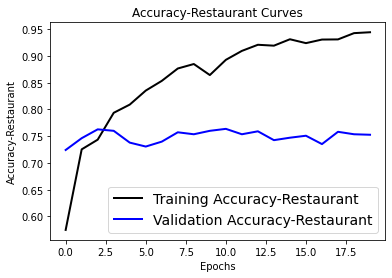

In [42]:
plotting_epochs(train_accuracy, test_accuracy, 'Accuracy-Restaurant')

## IAN Models

In [65]:
batch_size = 64
learning_rate = 0.01
n_epoch = 20

In [ ]:
model_2 = IAN(embeddings_matrix, embeddings_matrix_target)
train_accuracy, test_accuracy, train_loss, test_loss = run(model_2, data, data_test, stopping_accuracy=0.770)

Epoch 1/20 : 2.092sec
===============>  train-loss=0.864907; train-acc=0.636161; validation-loss=0.707815; validation-acc=0.737132
Classwise train accuracy: [0.341 0.146 0.891]
Classwise test accuracy: [0.596 0.016 0.968]
Epoch 2/20 : 2.031sec
===============>  train-loss=0.639775; train-acc=0.729353; validation-loss=0.561890; validation-acc=0.784007
Classwise train accuracy: [0.615 0.321 0.892]
Classwise test accuracy: [0.654 0.274 0.955]


The max accuracy of testing results: acc 0.784 of epoch 2


In [ ]:
train_accuracy, test_accuracy, train_loss, test_loss = run(model_2, data, data_test, stopping_accuracy=0.780)

Epoch 1/20 : 2.076sec
===============>  train-loss=0.671765; train-acc=0.730748; validation-loss=0.585529; validation-acc=0.764706
Classwise train accuracy: [0.584 0.342 0.9  ]
Classwise test accuracy: [0.766 0.184 0.92 ]
Epoch 2/20 : 2.032sec
===============>  train-loss=0.534544; train-acc=0.780134; validation-loss=0.569321; validation-acc=0.773897
Classwise train accuracy: [0.697 0.485 0.898]
Classwise test accuracy: [0.649 0.221 0.955]
Epoch 3/20 : 2.028sec
===============>  train-loss=0.445573; train-acc=0.824219; validation-loss=0.622087; validation-acc=0.770221
Classwise train accuracy: [0.763 0.583 0.918]
Classwise test accuracy: [0.527 0.389 0.937]
Epoch 4/20 : 2.029sec
===============>  train-loss=0.371756; train-acc=0.855190; validation-loss=0.711405; validation-acc=0.755515
Classwise train accuracy: [0.791 0.674 0.933]
Classwise test accuracy: [0.574 0.2   0.952]
Epoch 5/20 : 2.069sec
===============>  train-loss=0.344121; train-acc=0.865792; validation-loss=0.705799; valid

In [ ]:
train_accuracy, test_accuracy, train_loss, test_loss = run(model_2, data, data_test, stopping_accuracy=0.775)

Epoch 1/20 : 2.078sec
===============>  train-loss=0.126346; train-acc=0.955078; validation-loss=1.240771; validation-acc=0.748162
Classwise train accuracy: [0.932 0.919 0.974]
Classwise test accuracy: [0.564 0.268 0.925]
Epoch 2/20 : 2.042sec
===============>  train-loss=0.067260; train-acc=0.976283; validation-loss=1.307230; validation-acc=0.747243
Classwise train accuracy: [0.975 0.951 0.984]
Classwise test accuracy: [0.569 0.321 0.908]
Epoch 3/20 : 2.036sec
===============>  train-loss=0.059509; train-acc=0.981027; validation-loss=1.384049; validation-acc=0.756434
Classwise train accuracy: [0.979 0.952 0.99 ]
Classwise test accuracy: [0.59  0.311 0.92 ]
Epoch 4/20 : 2.010sec
===============>  train-loss=0.040884; train-acc=0.986049; validation-loss=1.307591; validation-acc=0.751838
Classwise train accuracy: [0.982 0.973 0.991]
Classwise test accuracy: [0.612 0.368 0.892]
Epoch 5/20 : 2.021sec
===============>  train-loss=0.044584; train-acc=0.983817; validation-loss=1.513942; valid

In [ ]:
model_2.save('/content/drive/MyDrive/DL/Assignment_4/Q2_model_rest', save_format="tf")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/Assignment_4/Q2_model_rest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DL/Assignment_4/Q2_model_rest/assets


In [66]:
model2 = load_model('/content/drive/MyDrive/DL/Assignment_4/Q2_model_rest')

In [67]:
run(model2, data, data_test, run_only='test')

Time: 0.381sec
===============>  validation-loss=0.561695; validation-acc=0.783088
Classwise test accuracy: [0.654 0.274 0.954]


In [68]:
data_test111 = X_test_padded_target[:64], X_test_padded[:64], y_test_laptop1[:64], np.full((64,), 15.), np.full((64,), 40.)
pred, lbl, att_aspect, att_context = model2(data_test111)

In [69]:
predict_list, labels_list = [], []
predict_list.extend(tf.argmax(tf.nn.softmax(pred), 1).numpy())
labels_list.extend(tf.argmax(lbl, 1).numpy())

### For 1st input, attention weights results

In [70]:
indx = 0

In [71]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded, corpus_test, att_context.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5
0,however,the,service,is,absolutely,horrible


In [72]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded_target, corpus_test_target, att_aspect.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0
0,service


In [73]:
print(corpus_test[indx], "\n==>", corpus_test_target[indx], "\n==>", list_emotions[predict_list[indx]])

however  the service is absolutely horrible  
==> service 
==> negative


### For 2nd input, attention weights results

In [74]:
indx = 20

In [75]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded, corpus_test, att_context.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,rice,dishes,and,noodle,dishes,rarely,exceed,5,and,add,on,a,refreshing,ice,drink,for,2,and,you,re,set,for,the


In [76]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded_target, corpus_test_target, att_aspect.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1
0,noodle,dishes


In [77]:
print(corpus_test[indx], "\n==>", corpus_test_target[indx], "\n==>", list_emotions[predict_list[indx]])

rice dishes and noodle dishes rarely exceed  5 and add on a refreshing ice drink for  2 and you re set for the night  
==> noodle dishes 
==> positive


### For 3rd input, attention weights results

In [78]:
indx = 10

In [79]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded, corpus_test, att_context.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,the,service,is,really,fast,and,friendly,and,the,value,is,great


In [80]:
tokenized_text, attention_output = getting_attention_weights(X_test_padded_target, corpus_test_target, att_aspect.numpy(), indx)
char_vals = [CharVal(c, v) for c, v in zip(tokenized_text, attention_output)]
char_df = pd.DataFrame(char_vals).transpose()
char_df = char_df.style.applymap(color_charvals)
char_df

,0
0,value


In [81]:
print(corpus_test[indx], "\n==>", corpus_test_target[indx], "\n==>", list_emotions[predict_list[indx]])

the service is really fast and friendly  and the value is great  
==> value 
==> positive


## OverSample

In [ ]:
batch_size = 64
learning_rate = 0.01
n_epoch = 10

In [ ]:
data11 = X_train_padded_target1, X_train_padded1, y_train_rest11, np.full((X_train_padded1.shape[0],), 15.), np.full((X_train_padded1.shape[0],), 40.)
data_test11 = X_test_padded_target, X_test_padded, y_test_rest1, np.full((X_test_padded.shape[0],), 15.), np.full((X_test_padded.shape[0],), 40.)

In [ ]:
model_2 = IAN(embeddings_matrix, embeddings_matrix_target)
train_accuracy, test_accuracy, train_loss, test_loss = run(model_2, data11, data_test11)

Epoch 1/10 : 60.343sec
===============>  train-loss=1.004570; train-acc=0.527073; validation-loss=1.085873; validation-acc=0.318934
Classwise train accuracy: [0.529 0.537 0.515]
Classwise test accuracy: [0.282 0.642 0.242]
Epoch 2/10 : 61.053sec
===============>  train-loss=0.966081; train-acc=0.521504; validation-loss=0.893319; validation-acc=0.629596
Classwise train accuracy: [0.508 0.62  0.437]
Classwise test accuracy: [0.197 0.3   0.832]
Epoch 3/10 : 60.321sec
===============>  train-loss=0.887793; train-acc=0.578125; validation-loss=1.193440; validation-acc=0.311581
Classwise train accuracy: [0.566 0.646 0.522]
Classwise test accuracy: [0.84  0.126 0.221]
Epoch 4/10 : 60.648sec
===============>  train-loss=0.820310; train-acc=0.609375; validation-loss=1.072648; validation-acc=0.510110
Classwise train accuracy: [0.605 0.671 0.552]
Classwise test accuracy: [0.479 0.421 0.542]
Epoch 5/10 : 60.153sec
===============>  train-loss=0.775622; train-acc=0.634127; validation-loss=1.031303; 

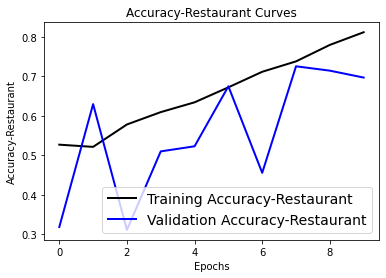

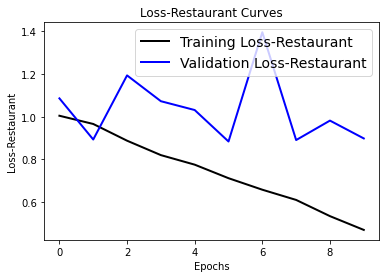

In [ ]:
plotting_epochs(train_accuracy, test_accuracy, 'Accuracy-Restaurant')
plotting_epochs(train_loss, test_loss, 'Loss-Restaurant')

In [ ]:
train_accuracy, test_accuracy, train_loss, test_loss = run(model_2, data11, data_test11)

Epoch 1/10 : 60.083sec
===============>  train-loss=0.471553; train-acc=0.812500; validation-loss=0.909044; validation-acc=0.681066
Classwise train accuracy: [0.808 0.812 0.817]
Classwise test accuracy: [0.654 0.384 0.768]
Epoch 2/10 : 60.260sec
===============>  train-loss=0.392923; train-acc=0.846999; validation-loss=0.907010; validation-acc=0.697610
Classwise train accuracy: [0.844 0.854 0.843]
Classwise test accuracy: [0.468 0.4   0.838]
Epoch 3/10 : 60.071sec
===============>  train-loss=0.403199; train-acc=0.843131; validation-loss=0.878649; validation-acc=0.727941
Classwise train accuracy: [0.836 0.851 0.842]
Classwise test accuracy: [0.585 0.379 0.859]
Epoch 4/10 : 59.911sec
===============>  train-loss=0.330511; train-acc=0.878094; validation-loss=1.006609; validation-acc=0.697610
Classwise train accuracy: [0.877 0.883 0.874]
Classwise test accuracy: [0.702 0.316 0.799]
Epoch 5/10 : 59.969sec
===============>  train-loss=0.306518; train-acc=0.887531; validation-loss=1.114889; 

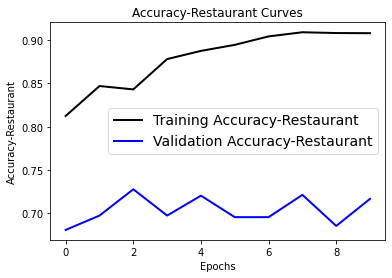

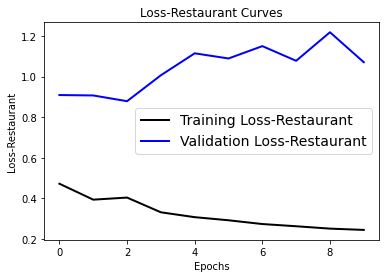

In [ ]:
plotting_epochs(train_accuracy, test_accuracy, 'Accuracy-Restaurant')
plotting_epochs(train_loss, test_loss, 'Loss-Restaurant')